In [2]:
import pandas
import numpy

data = pandas.read_csv('reliance.bse.csv')
print(data.keys())

Index(['timestamp', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient'],
      dtype='object')


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

In [4]:
data['time'] = pandas.to_datetime(data.timestamp,format='%Y-%m-%d')
data.drop('timestamp', inplace=True, axis=1)
data.drop('dividend_amount', inplace=True, axis=1)
data.index = data.time
data = data.sort_index(ascending=True)

new_data = pandas.DataFrame(index=range(0,len(data)),columns=['time', 'close'])
for i in range(0,len(data)):
    new_data['time'][i] = data['time'][i]
    new_data['close'][i] = data['close'][i]

new_data.index = new_data.time
new_data.drop('time', axis=1, inplace=True)
data.drop('time', inplace=True, axis=1)
new_data

,close
time,
2005-01-03,405.9997
2005-01-04,396.8048
2005-01-05,396.1319
2005-01-06,393.1791
2005-01-07,404.3176
...,...
2022-11-15,2606.7
2022-11-16,2591.8501
2022-11-17,2601.3


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
fdata = scaler.fit_transform(new_data.values)
l = int(len(fdata)*0.7)
r = len(fdata) - l
x_train = []
y_train = []
for i in range(60, l):
    x_train.append(fdata[i-60:i])
    y_train.append(fdata[i])
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)
print(len(x_train),x_train.shape)
print(len(y_train),y_train.shape)

3024 (3024, 60, 1)
3024 (3024, 1)


In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=2)

2022-11-25 21:44:54.680716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 21:44:54.696823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 21:44:54.698287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-25 21:44:54.701837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-25 21:44:54.702213: W tensorf

Epoch 1/10
303/303 - 22s - loss: 0.0027 - 22s/epoch - 74ms/step
Epoch 2/10
303/303 - 12s - loss: 7.6763e-04 - 12s/epoch - 39ms/step
Epoch 3/10
303/303 - 11s - loss: 6.4906e-04 - 11s/epoch - 38ms/step
Epoch 4/10
303/303 - 12s - loss: 6.1547e-04 - 12s/epoch - 38ms/step
Epoch 5/10
303/303 - 12s - loss: 4.9538e-04 - 12s/epoch - 40ms/step
Epoch 6/10
303/303 - 12s - loss: 4.4596e-04 - 12s/epoch - 39ms/step
Epoch 7/10
303/303 - 12s - loss: 3.6827e-04 - 12s/epoch - 40ms/step
Epoch 8/10
303/303 - 15s - loss: 3.2912e-04 - 15s/epoch - 50ms/step
Epoch 9/10
303/303 - 14s - loss: 2.8089e-04 - 14s/epoch - 47ms/step
Epoch 10/10
303/303 - 14s - loss: 2.7382e-04 - 14s/epoch - 47ms/step


In [7]:
x_test = []
y_test = []
for i in range(l,l+r):
    x_test.append(fdata[i-60:i])
    y_test.append(fdata[i])
x_test = numpy.array(x_test)
y_test = numpy.array(y_test)
print(len(x_test),x_test.shape)
print(len(y_test),y_test.shape)

1322 (1322, 60, 1)
1322 (1322, 1)


In [8]:
closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)
rms=numpy.sqrt(numpy.mean(numpy.power((y_test-closing_price),2)))
print(rms)
len(closing_price)

42/42 [==============================] - 4s 38ms/step
1766.8541740746314


1322

/tmp/ipykernel_7001/1464317647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


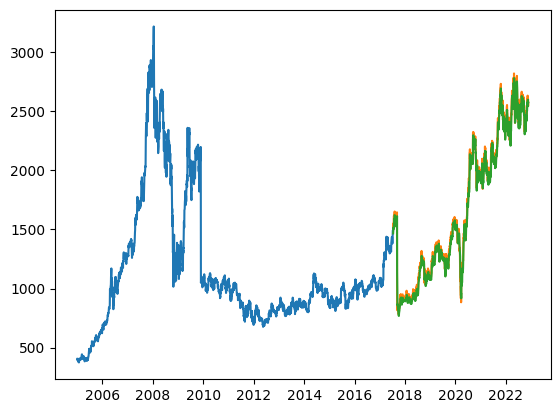

In [11]:
train = new_data[:l]
valid = new_data[l:]
valid['Predictions'] = closing_price

plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.savefig(fname='/mnt/d/Major Project/project1/backend/output.png')

In [ ]:
gdata = fdata.copy()

In [ ]:
input = input = gdata[-60:]
print(input)
x = model.predict(numpy.array([input]))
x = scaler.inverse_transform(x)
print(x)

[[0.79684864]
 [0.79383964]
 [0.78970446]
 [0.78197959]
 [0.79686627]
 [0.76909894]
 [0.75840027]
 [0.77263584]
 [0.78148685]
 [0.77647185]
 [0.7778972 ]
 [0.77205519]
 [0.78226117]
 [0.79019712]
 [0.77881222]
 [0.76964444]
 [0.74766639]
 [0.74873982]
 [0.7486342 ]
 [0.7511681 ]
 [0.74295049]
 [0.72656821]
 [0.7048013 ]
 [0.71110081]
 [0.6888237 ]
 [0.68643054]
 [0.70487168]
 [0.70367512]
 [0.71731241]
 [0.72069091]
 [0.7244214 ]
 [0.71474332]
 [0.69767471]
 [0.70393907]
 [0.70703609]
 [0.70251375]
 [0.71623903]
 [0.7305098 ]
 [0.74668099]
 [0.74822945]
 [0.7380411 ]
 [0.74076856]
 [0.72744804]
 [0.73035146]
 [0.75706293]
 [0.76535089]
 [0.75838267]
 [0.76389034]
 [0.76760324]
 [0.78044869]
 [0.7852701 ]
 [0.78416156]
 [0.77411395]
 [0.79413881]
 [0.78942291]
 [0.7854637 ]
 [0.78023757]
 [0.78356328]
 [0.78224354]
 [0.76552685]]
1/1 [==============================] - 0s 29ms/step
[[2534.7017]]


In [ ]:
print(scaler.inverse_transform(input))

[[2639.05  ]
 [2630.5   ]
 [2618.75  ]
 [2596.8   ]
 [2639.1001]
 [2560.2   ]
 [2529.8   ]
 [2570.25  ]
 [2595.3999]
 [2581.1499]
 [2585.2   ]
 [2568.6001]
 [2597.6001]
 [2620.1499]
 [2587.8   ]
 [2561.75  ]
 [2499.3   ]
 [2502.3501]
 [2502.05  ]
 [2509.25  ]
 [2485.8999]
 [2439.3501]
 [2377.5   ]
 [2395.3999]
 [2332.1001]
 [2325.3   ]
 [2377.7   ]
 [2374.3   ]
 [2413.05  ]
 [2422.6499]
 [2433.25  ]
 [2405.75  ]
 [2357.25  ]
 [2375.05  ]
 [2383.8501]
 [2371.    ]
 [2410.    ]
 [2450.55  ]
 [2496.5   ]
 [2500.8999]
 [2471.95  ]
 [2479.7   ]
 [2441.8501]
 [2450.1001]
 [2526.    ]
 [2549.55  ]
 [2529.75  ]
 [2545.3999]
 [2555.95  ]
 [2592.45  ]
 [2606.1499]
 [2603.    ]
 [2574.45  ]
 [2631.3501]
 [2617.95  ]
 [2606.7   ]
 [2591.8501]
 [2601.3   ]
 [2597.55  ]
 [2550.05  ]]


In [ ]:
input = x_test[0]

closing_price = []
for i in range(1322):
    input = gdata[l+i-60:l+i]
    # print(input)
    nv = model.predict(numpy.array([input]))
    # print(nv)
    closing_price.append(nv)
    # print(gdata[l+i])
    gdata[l+i] = nv[0][0]
    # print(gdata[l+i])
closing_price = numpy.array(closing_price)

1/1 [==============================] - 0s 23ms/step


In [ ]:
nl = []
for i in range(len(closing_price)):
    nl.append(closing_price[i][0])
nl = numpy.array(nl)
print(nl)

[[0.39376256]
 [0.3936768 ]
 [0.39346054]
 ...
 [0.4774873 ]
 [0.4774873 ]
 [0.4774873 ]]


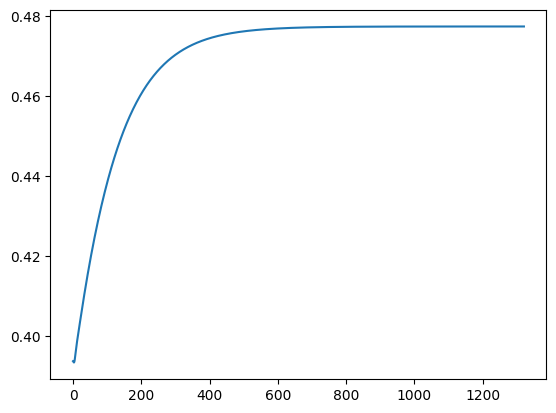

In [ ]:
plt.plot(nl)

In [ ]:
closing_price = closing_price.reshape((len(closing_price),1))

1708.9969492388034
[[1493.6919]
 [1493.4482]
 [1492.8337]
 ...
 [1731.5934]
 [1731.5934]
 [1731.5934]]


C:\Users\1mana\AppData\Local\Temp\ipykernel_14944\247282063.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


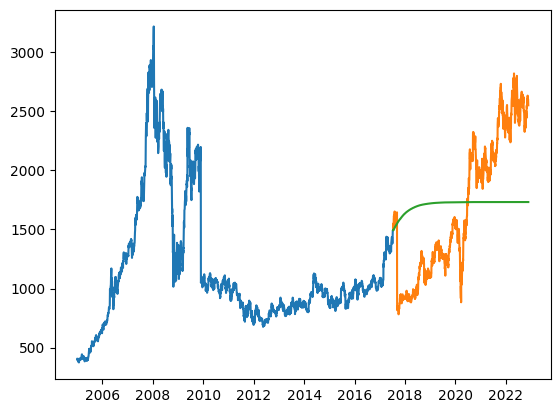

In [ ]:
closing_price = scaler.inverse_transform(closing_price)
rms=numpy.sqrt(numpy.mean(numpy.power((y_test-closing_price),2)))
print(rms)
print(closing_price)

train = new_data[:l]
valid = new_data[l:]
valid['Predictions'] = closing_price

plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])